<a href="https://colab.research.google.com/github/psynimq/Hanfeizi_Zhanguoce_authorship_attribution/blob/main/Bert_hanfeizi_final_ver2%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT을 통한 딥러닝 분류 학습

사용 알고리즘:  BERT Fine-Tuning Tutorial with PyTorch
-> https://mccormickml.com/2019/07/22/BERT-fine-tuning

* 본 내용은 https://colab.research.google.com/drive/1h7Xo23ZfYm4Gx2YXfOKnSZtNPhHvVt2U 를 토대로 수정하였습니다.


In [ ]:
#@title 환경설정

# Hugging Face의 트랜스포머 모델을 설치
!pip install transformers

import sys

from IPython.display import clear_output
clear_output(wait=True)

## 관련 라이브러스 설치
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import keras
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

clear_output()

print('Python version : ', sys.version)
print('TensorFlow version : ', tf.__version__)
print('Keras version : ', keras.__version__)

Python version :  3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
TensorFlow version :  2.7.0
Keras version :  2.7.0


## 데이터 불러오기

In [ ]:
#@title 데이터 불러오기
구글드라이브ID = '1RAAYXlE4ciDNhxukVN_j7cNSx6QluJTR'  #@param {type: "string"}
파일저장이름 = 'rawdata_final_ver2'  #@param {type: "string"}

# 구글 드라이브 연결을 위한 기본 세팅
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

rawdata_downloaded = drive.CreateFile({'id': 구글드라이브ID })
rawdata_downloaded.GetContentFile(파일저장이름)

print(파일저장이름+"을 정상적으로 가져왔습니다.")

# 파일을 DataFrame으로 전환
df = pd.read_csv(파일저장이름, sep='\t')
df

rawdata_final_ver2을 정상적으로 가져왔습니다.


,label,chapter,text_content
0,韓非子,主道,道者萬物之始是非之紀也是以明君守始以知萬物之源治紀以知善敗之端故虛靜以待令令名自命也令事自定...
1,韓非子,主道,故曰寂乎其無位而處漻乎莫得其所明君無為於上群臣竦懼乎下明君之道使智者盡其慮而君因以斷事故君不...
2,韓非子,主道,道在不可見用在不可知虛靜無事以闇見疵見而不見聞而不聞知而不知知其言以往勿變勿更以參合閱焉官有...
3,韓非子,主道,是故人主有五壅臣閉其主曰壅臣制財利曰壅臣擅行令曰壅臣得行義曰壅臣得樹人曰壅臣閉其主則主失位臣...
4,韓非子,主道,人主之道靜退以為寶不自操事而知拙與巧不自計慮而知福與咎是以不言而善應不約而善增言已應則執其契...
...,...,...,...
1623,戰國策,趙策,王召趙勝趙禹而告之曰韓不能守上黨今其守以與寡人有城市之邑十七二人對曰用兵逾年未得一城今坐而得...
1624,戰國策,趙策,諒毅親受命而往至秦獻書秦王曰大王廣地寧邑諸侯皆賀敝邑寡君亦竊嘉之不敢寧居使下臣奉其幣物三至王...
1625,戰國策,齊策,淳於髡一日而見七人於宣王
1626,戰國策,秦策,天下之士合從相聚於趙而欲攻秦秦相應侯曰王勿憂也請令廢之秦於天下之士非有怨也相聚而攻秦者以己欲...


In [ ]:
print(df["label"].groupby([df["label"]]).count())

label
戰國策    814
韓非子    814
Name: label, dtype: int64


In [ ]:
## 텍스트로 되어 있는 라벨을 숫자로 변환
df.loc[df.label=='韓非子', 'label']='0'
df.loc[df.label=='戰國策', 'label']='1'

df

,label,chapter,text_content
0,0,主道,道者萬物之始是非之紀也是以明君守始以知萬物之源治紀以知善敗之端故虛靜以待令令名自命也令事自定...
1,0,主道,故曰寂乎其無位而處漻乎莫得其所明君無為於上群臣竦懼乎下明君之道使智者盡其慮而君因以斷事故君不...
2,0,主道,道在不可見用在不可知虛靜無事以闇見疵見而不見聞而不聞知而不知知其言以往勿變勿更以參合閱焉官有...
3,0,主道,是故人主有五壅臣閉其主曰壅臣制財利曰壅臣擅行令曰壅臣得行義曰壅臣得樹人曰壅臣閉其主則主失位臣...
4,0,主道,人主之道靜退以為寶不自操事而知拙與巧不自計慮而知福與咎是以不言而善應不約而善增言已應則執其契...
...,...,...,...
1623,1,趙策,王召趙勝趙禹而告之曰韓不能守上黨今其守以與寡人有城市之邑十七二人對曰用兵逾年未得一城今坐而得...
1624,1,趙策,諒毅親受命而往至秦獻書秦王曰大王廣地寧邑諸侯皆賀敝邑寡君亦竊嘉之不敢寧居使下臣奉其幣物三至王...
1625,1,齊策,淳於髡一日而見七人於宣王
1626,1,秦策,天下之士合從相聚於趙而欲攻秦秦相應侯曰王勿憂也請令廢之秦於天下之士非有怨也相聚而攻秦者以己欲...


In [ ]:
## NAN 값 제거
df.dropna(axis=0)
df

,label,chapter,text_content
0,0,主道,道者萬物之始是非之紀也是以明君守始以知萬物之源治紀以知善敗之端故虛靜以待令令名自命也令事自定...
1,0,主道,故曰寂乎其無位而處漻乎莫得其所明君無為於上群臣竦懼乎下明君之道使智者盡其慮而君因以斷事故君不...
2,0,主道,道在不可見用在不可知虛靜無事以闇見疵見而不見聞而不聞知而不知知其言以往勿變勿更以參合閱焉官有...
3,0,主道,是故人主有五壅臣閉其主曰壅臣制財利曰壅臣擅行令曰壅臣得行義曰壅臣得樹人曰壅臣閉其主則主失位臣...
4,0,主道,人主之道靜退以為寶不自操事而知拙與巧不自計慮而知福與咎是以不言而善應不約而善增言已應則執其契...
...,...,...,...
1623,1,趙策,王召趙勝趙禹而告之曰韓不能守上黨今其守以與寡人有城市之邑十七二人對曰用兵逾年未得一城今坐而得...
1624,1,趙策,諒毅親受命而往至秦獻書秦王曰大王廣地寧邑諸侯皆賀敝邑寡君亦竊嘉之不敢寧居使下臣奉其幣物三至王...
1625,1,齊策,淳於髡一日而見七人於宣王
1626,1,秦策,天下之士合從相聚於趙而欲攻秦秦相應侯曰王勿憂也請令廢之秦於天下之士非有怨也相聚而攻秦者以己欲...


In [ ]:
print(df["label"].groupby([df["label"]]).count())

label
0    814
1    814
Name: label, dtype: int64


In [ ]:
## label 값을 숫자로 전환
df['label'] = df['label'].apply(pd.to_numeric) 

print(df)

      label chapter                                       text_content
0         0      主道  道者萬物之始是非之紀也是以明君守始以知萬物之源治紀以知善敗之端故虛靜以待令令名自命也令事自定...
1         0      主道  故曰寂乎其無位而處漻乎莫得其所明君無為於上群臣竦懼乎下明君之道使智者盡其慮而君因以斷事故君不...
2         0      主道  道在不可見用在不可知虛靜無事以闇見疵見而不見聞而不聞知而不知知其言以往勿變勿更以參合閱焉官有...
3         0      主道  是故人主有五壅臣閉其主曰壅臣制財利曰壅臣擅行令曰壅臣得行義曰壅臣得樹人曰壅臣閉其主則主失位臣...
4         0      主道  人主之道靜退以為寶不自操事而知拙與巧不自計慮而知福與咎是以不言而善應不約而善增言已應則執其契...
...     ...     ...                                                ...
1623      1      趙策  王召趙勝趙禹而告之曰韓不能守上黨今其守以與寡人有城市之邑十七二人對曰用兵逾年未得一城今坐而得...
1624      1      趙策  諒毅親受命而往至秦獻書秦王曰大王廣地寧邑諸侯皆賀敝邑寡君亦竊嘉之不敢寧居使下臣奉其幣物三至王...
1625      1      齊策                                       淳於髡一日而見七人於宣王
1626      1      秦策  天下之士合從相聚於趙而欲攻秦秦相應侯曰王勿憂也請令廢之秦於天下之士非有怨也相聚而攻秦者以己欲...
1627      1      趙策  以奉陽君甚食之唯得大封齊無大異臣愿足下之大肆發攻宋之舉而無庸致兵姑待以耕以觀奉陽君之應足下也...

[1628 rows x 3 columns]


In [ ]:
## 훈련데이터와 테스트데이터로 분리
훈련데이터비율 = 0.9

import numpy as np

train=df.sample(frac=훈련데이터비율,random_state=200)
test=df.drop(train.index)

#train.drop_duplicates(subset = ['text'], inplace=True) # text 열에서 중복인 내용이 있다면 중복 제거
train['text_content'] = train['text_content'].str.replace("。","") # 정규 표현식 수행
train['text_content'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
train = train.dropna(how='any') # Null 값 제거
print('전처리 후 훈련용 샘플의 개수 :',len(train))

#test.drop_duplicates(subset = ['text'], inplace=True) # text 열에서 중복인 내용이 있다면 중복 제거
test['text_content'] = test['text_content'].str.replace("。","") # 정규 표현식 수행
test['text_content'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test = test.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test))


전처리 후 훈련용 샘플의 개수 : 1465
전처리 후 테스트용 샘플의 개수 : 163


In [ ]:
df

,label,chapter,text_content
0,0,主道,道者萬物之始是非之紀也是以明君守始以知萬物之源治紀以知善敗之端故虛靜以待令令名自命也令事自定...
1,0,主道,故曰寂乎其無位而處漻乎莫得其所明君無為於上群臣竦懼乎下明君之道使智者盡其慮而君因以斷事故君不...
2,0,主道,道在不可見用在不可知虛靜無事以闇見疵見而不見聞而不聞知而不知知其言以往勿變勿更以參合閱焉官有...
3,0,主道,是故人主有五壅臣閉其主曰壅臣制財利曰壅臣擅行令曰壅臣得行義曰壅臣得樹人曰壅臣閉其主則主失位臣...
4,0,主道,人主之道靜退以為寶不自操事而知拙與巧不自計慮而知福與咎是以不言而善應不約而善增言已應則執其契...
...,...,...,...
1623,1,趙策,王召趙勝趙禹而告之曰韓不能守上黨今其守以與寡人有城市之邑十七二人對曰用兵逾年未得一城今坐而得...
1624,1,趙策,諒毅親受命而往至秦獻書秦王曰大王廣地寧邑諸侯皆賀敝邑寡君亦竊嘉之不敢寧居使下臣奉其幣物三至王...
1625,1,齊策,淳於髡一日而見七人於宣王
1626,1,秦策,天下之士合從相聚於趙而欲攻秦秦相應侯曰王勿憂也請令廢之秦於天下之士非有怨也相聚而攻秦者以己欲...


## 데이터 전처리 with bert

In [ ]:
#@title 학습 데이터 처리 - BERT형식으로 변환

# 리뷰 문장 추출
sentences = train['text_content']
print('')
print('##### 원본 데이터 #####')
print(sentences[:10])

# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
print('')
print('##### Bert 형식으로 변환 #####')
print(sentences[:10])


# 라벨 추출
labels = train['label'].values

print('')
print('##### 라벨 추출 #####')
print(labels)


##### 원본 데이터 #####
42      舜禪天下而傳之於禹禹作為祭器墨染其外而朱畫其內縵帛為茵蔣席頗緣觴酌有采而樽俎有飾此彌侈矣而國...
1145         牛贊再拜稽首曰臣敢不聽令乎至遂胡服率騎入胡出於遺遺之門逾九限之固絕五俓之險至榆中辟地千里
24      明主之為官職爵祿也所以進賢材勸有功也故曰賢材者處厚祿任大官功大者有尊爵受重賞官賢者量其能賦祿...
1542    韓非知之曰賈以珍珠重寶南使荊吳北使燕代之間三年四國之交未必合也而珍珠重寶盡於內是賈以王之權國...
1432    秦惠王死公孫衍欲窮張儀李讎謂公孫衍曰不如召甘茂於魏召公孫顯於韓起樗裡子於國三人者皆張儀之讎也...
955     五國伐秦無功罷於成皋趙欲構於秦楚與魏韓將應之秦弗欲蘇代謂齊王曰臣以為足下見奉陽君矣臣謂奉陽君...
877                                                蘇秦說齊閔王
662     秦昭王問於左右曰今時韓魏孰與始強左右對曰弱於始也今之如耳魏齊孰與曩之孟常芒卯對曰不及也王曰孟...
867                                                 樓梧約秦魏
528     子產者子國之子也子產忠於鄭君子國譙怒之曰夫介異於人臣而獨忠於主主賢明能聽汝不明將不汝聽聽與不...
Name: text_content, dtype: object

##### Bert 형식으로 변환 #####
['[CLS] 舜禪天下而傳之於禹禹作為祭器墨染其外而朱畫其內縵帛為茵蔣席頗緣觴酌有采而樽俎有飾此彌侈矣而國之不服者三十三夏后氏沒殷人受之作為大路而建九旒食器雕琢觴酌刻鏤四壁堊墀茵席雕文此彌侈矣而國之不服者五十三君子皆知文章矣而欲服者彌少臣故曰儉其道也由余出公乃召內史廖而告之曰寡人聞鄰國有聖人敵國之憂也今由余聖人也寡人患之吾將奈何內史廖曰臣聞戎王之居僻陋而道遠未聞中國之聲君其遺之女樂以亂其政而後為由余請期以疏其諫彼君臣有間而後可圖也 [SEP]', '[CLS] 牛贊再拜稽首曰臣敢不聽令乎至遂胡服率騎入胡出於遺遺之門逾九限之固絕五俓之險至榆中辟地千里 [SEP]', '[CLS] 明主之為官職爵祿也所以進賢材勸有功也故曰賢材者處厚祿任大官功大者有尊爵受重賞官賢者量其能賦祿

![대체 텍스트](https://mino-park7.github.io/images/2019/02/bert-input-representation.png)

BERT의 입력은 위의 그림과 같은 형식입니다. Classification을 뜻하는 [CLS] 심볼이 제일 앞에 삽입됩니다. 파인튜닝시 출력에서 이 위치의 값을 사용하여 분류를 합니다. [SEP]은 Seperation을 가리키는데, 두 문장을 구분하는 역할을 합니다. 이 예제에서는 문장이 하나이므로 [SEP]도 하나만 넣습니다.
<br>
<br>
<br>

In [ ]:
#@title 학습 데이터 처리 - BERT로 임베딩하기

bert모델 = "bert-base-chinese"  #@param ['bert-base-multilingual-cased', 'bert-large-cased', 'bert-base-chinese']

#"bert-base-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json",
#"bert-large-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-config.json",
#"bert-base-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json",
#"bert-large-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-config.json",
#"bert-base-multilingual-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json",
#"bert-base-multilingual-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json",
#"bert-base-chinese": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-config.json",
#"bert-base-german-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-cased-config.json",
#"bert-large-uncased-whole-word-masking": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-config.json",
#"bert-large-cased-whole-word-masking": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-config.json",
#"bert-large-uncased-whole-word-masking-finetuned-squad": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-finetuned-squad-config.json",
#"bert-large-cased-whole-word-masking-finetuned-squad": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-finetuned-squad-config.json",
#"bert-base-cased-finetuned-mrpc": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-finetuned-mrpc-config.json",
#"bert-base-german-dbmdz-cased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-dbmdz-cased-config.json",
#"bert-base-german-dbmdz-uncased": "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-dbmdz-uncased-config.json",
#"bert-base-japanese": "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-config.json",
#"bert-base-japanese-whole-word-masking": "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-whole-word-masking-config.json",
#"bert-base-japanese-char": "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-char-config.json",
#"bert-base-japanese-char-whole-word-masking": "https://s3.amazonaws.com/models.huggingface.co/bert/cl-tohoku/bert-base-japanese-char-whole-word-masking-config.json",
#"bert-base-finnish-cased-v1": "https://s3.amazonaws.com/models.huggingface.co/bert/TurkuNLP/bert-base-finnish-cased-v1/config.json",
#"bert-base-finnish-uncased-v1": "https://s3.amazonaws.com/models.huggingface.co/bert/TurkuNLP/bert-base-finnish-uncased-v1/config.json",


# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained(bert모델, do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

[CLS] 舜禪天下而傳之於禹禹作為祭器墨染其外而朱畫其內縵帛為茵蔣席頗緣觴酌有采而樽俎有飾此彌侈矣而國之不服者三十三夏后氏沒殷人受之作為大路而建九旒食器雕琢觴酌刻鏤四壁堊墀茵席雕文此彌侈矣而國之不服者五十三君子皆知文章矣而欲服者彌少臣故曰儉其道也由余出公乃召內史廖而告之曰寡人聞鄰國有聖人敵國之憂也今由余聖人也寡人患之吾將奈何內史廖曰臣聞戎王之居僻陋而道遠未聞中國之聲君其遺之女樂以亂其政而後為由余請期以疏其諫彼君臣有間而後可圖也 [SEP]
['[CLS]', '舜', '禪', '天', '下', '而', '傳', '之', '於', '禹', '禹', '作', '為', '祭', '器', '墨', '染', '其', '外', '而', '朱', '畫', '其', '內', '[UNK]', '帛', '為', '茵', '蔣', '席', '頗', '緣', '[UNK]', '酌', '有', '采', '而', '樽', '俎', '有', '飾', '此', '彌', '侈', '矣', '而', '國', '之', '不', '服', '者', '三', '十', '三', '夏', '后', '氏', '沒', '殷', '人', '受', '之', '作', '為', '大', '路', '而', '建', '九', '[UNK]', '食', '器', '雕', '琢', '[UNK]', '酌', '刻', '鏤', '四', '壁', '[UNK]', '墀', '茵', '席', '雕', '文', '此', '彌', '侈', '矣', '而', '國', '之', '不', '服', '者', '五', '十', '三', '君', '子', '皆', '知', '文', '章', '矣', '而', '欲', '服', '者', '彌', '少', '臣', '故', '曰', '儉', '其', '道', '也', '由', '余', '出', '公', '乃', '召', '內', '史', '廖', '而', '告', '之', '曰', '寡', '人', '聞', '鄰', '國', '有', '聖', '人', '敵', '國', '之', '憂', '也', '今', '由', '余', '聖', '人', '也

BERT는 형태소분석으로 토큰을 분리하지 않습니다. WordPiece라는 통계적인 방식을 사용합니다. 한 단어내에서 자주 나오는 글자들을 붙여서 하나의 토큰으로 만듭니다. 이렇게 하면 언어에 상관없이 토큰을 생성할 수 있다는 장점이 있습니다. 또한 신조어 같이 사전에 없는 단어를 처리하기도 좋습니다. 

토크나이저는 'bert-base-chinese'를 사용합니다.
<br>
<br>
<br>

리뷰의 최대 길이 : 243
리뷰의 평균 길이 : 108.64368600682594


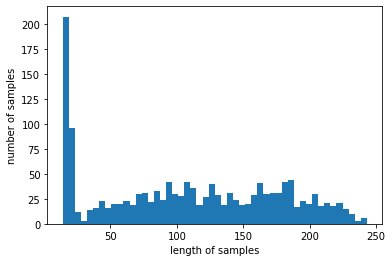

전체 샘플 중 길이가 265 이하인 샘플의 비율: 100.0


In [ ]:
#@title 전처리를 위한 문장 길이 조회

## 전처리를 위한 기본 텍스트 정보를 탐색합니다.

최대길이 = "265"  #@param ['32', '64', '128', '256', '265']
최대길이 = int(최대길이)

print('문단의 최대 길이 :',max(len(l) for l in sentences))
## 문단의 최대 길이는 가장 긴 문단의 길이를 의미합니다.

print('문단의 평균 길이 :',sum(map(len, sentences))/len(sentences))
## 문단의 평균 길이는 문단 길이의 평균값을 의미합니다.

import matplotlib.pyplot as plt

plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 문장 길이 전체 그래프를 살펴보면, 문단의 전체 분포를 볼 수 있습니다.
## 대다수의 문단이 250자 이하인 것을 알 수 있습니다.


def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))


max_len = 최대길이
below_threshold_len(max_len, sentences) 

## max_leb(문장 최대 길이)가 265일때 선택되는 전체 데이터량을 의미합니다.
## 모든 데이터가 선택된 것을 확인할 수 있습니다.

In [ ]:
#@title 패딩 및 어텐션 마스크 세팅

# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 최대길이

## 입력 문장의 최대 길이를 지정해줍니다. 
## MAX_LEN을 256, 512 등 더 크게 변경할 수도 있습니다. 그러면 처리 시간이 더 걸립니다. 대신 정확도는 상승합니다.
## 반대로 MAX_LEN을 64, 32 등 더 작게 변경할 수도 있습니다. 그러면 처리 시간은 짦아지고, 정확도는 줄어듭니다.
## MAX_LEN에 "정답"은 없습니다. 적절한 길이를 선택해야 합니다.

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
## 패딩이란 MAX_LEN보다 짦은 문장에 적용합니다. 문장 길이가 120이라면 8개가 패딩으로 채워지게 됩니다.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

print(input_ids[0])

# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[ 101 5658 4890 1921  678 5445 1001  722 3176 4893 4893  868 4158 4874
 1690 1874 3381 1071 1912 5445 3319 4529 1071 1058  100 2368 4158 5762
 5919 2375 7525 5225  100 6980 3300 7023 5445 3574  917 3300 7617 3634
 2493  890 4760 5445 1751  722  679 3302 5442  676 1282  676 1909 1400
 3694 3760 3668  782 1358  722  868 4158 1920 6662 5445 2456  736  100
 7608 1690 7425 4423  100 6980 1174 7130 1724 1880  100 1861 5762 2375
 7425 3152 3634 2493  890 4760 5445 1751  722  679 3302 5442  758 1282
  676 1409 2094 4639 4761 3152 4995 4760 5445 3617 3302 5442 2493 2208
 5628 3125 3288 1025 1071 6887  738 4507  865 1139 1062  718 1374 1058
 1380 2445 5445 1440  722 3288 2176  782 5472 6973 1751 3300 5469  782
 3147 1751  722 2726  738  791 4507  865 5469  782  738 2176  782 2642
  722 1434 2200 1937  862 1058 1380 2445 3288 5628 5472 2766 4374  722
 2233 1020 7358 5445 6887 6895 3313 5472  704 1751  722 5476 1409 1071
 6909  722 1957 3556  809  748 1071 3124 5445 2527 4158 4507  865 6313
 3309 

In [ ]:
#@title 훈련데이터와 검증 데이터 분리 및 배치 세팅

검증데이터비율 = "0.1"  #@param ['0.1', '0.2', '0.3']

배치크기 = "16"  #@param ['8', '16', '32', '64', '128', '256']
배치크기 = int(배치크기)


# 훈련셋과 검증셋으로 분리
validation_size = 검증데이터비율
## 훈련셋과 검증셋은 9:1로 분리해줍니다. 숫자를 변경하면 비율을 변경할 수 있습니다.

random_state = 1
## 컴퓨터에서의 분리는 시간값을 토대로 하는 랜덤입니다. 
## 하지만 완전히 랜덤으로 하면 학습마다 다른 결과가 나오는 문제가 발생합니다.
## 이를 통제하기 위해서 랜덤 시작값을 세팅해줍니다.

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=random_state, 
                                                                                    test_size=0.1)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=random_state, 
                                                       test_size=0.1)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)				

print("##### 훈련 텍스트의 bert embedding값 #####")
print(train_inputs[0])
print("##### 훈련 텍스트의 label 값 #####")
print(train_labels[0])
print("##### 훈련 텍스트의 MASK값 = 패딩 여부 확인 #####")
print(train_masks[0])
print("##### 검증 텍스트의 bert embedding값 #####")
print(validation_inputs[0])
print("##### 검증 텍스트의 label 값 #####")
print(validation_labels[0])
print("##### 검증 텍스트의 MASK값 = 패딩 여부 확인 #####")
print(validation_masks[0])


# 배치 사이즈
batch_size = 배치크기

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)



##### 훈련 텍스트의 bert embedding값 #####
tensor([ 101, 1298, 3448,  722, 7432, 7502, 3694, 6313, 3131, 3176, 7968, 4506,
         908, 1374, 1920, 5628, 5445, 6331, 3288, 3193, 3131,  722, 2115, 5645,
        3241, 3131,  722,  912, 2484,  681, 2205, 3288, 3241, 3131,  722, 7502,
         684, 2835, 5445, 1057, 3176, 7794,  679, 1963, 3193, 3131,  722, 4506,
        5628, 2590, 3288,  679, 1377, 1923, 7502, 7794,  722, 1070, 3313, 2464,
        5445, 2769, 3131,  722, 2769,  807, 7502, 5445, 1358, 7794,  722, 1070,
        7547, 1353, 5481, 1462, 3176, 7502,  738,  684, 1923, 7794, 3300, 4788,
        7502,  722, 2562, 7502, 6210,  684,  767, 2553, 3346,  100, 3176, 7968,
        2769, 1728, 7374, 5178, 7502,  722, 6217, 5445, 3241, 2824, 7794,  722,
        2464, 1179, 1751, 1377, 7028, 1164, 1377, 2533, 1399, 1377, 2203, 4760,
        4506,  908, 3288, 1587,  718, 7374, 1440, 7502,  886, 5442, 5445, 6897,
         722, 7502, 5632,  809, 2201, 3300, 7968, 1751,  758, 2782,  758,  679,
    

In [ ]:
#@title 테스트 데이터 처리(훈련데이터와 동일)

# 문장 추출
sentences = test['text_content']

# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]

# 라벨 추출
labels = test['label'].values

# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained(bert모델, do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=최대길이, dtype="long", truncating="post", padding="post")

# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

# 데이터를 파이토치의 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=배치크기)

## 모델 세팅

In [ ]:
#@title GPU 세팅

## 해당 부분에서 에러가 나면, "런타임 > 런타임 유형 변경 > 하드웨어 가속시 > GPU"로 변경해야 합니다.

# GPU 디바이스 이름 구함
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [ ]:
#@title 딥러닝 모델 세팅

# 분류를 위한 BERT 모델 생성
## 이미 bert를 통한 분류 모델이 만들어져 있습니다. 모델을 불러오기만 하면 됩니다.
## num_labels를 통해서 분류 갯수를 지정해줍니다. 韓非子-戰國策의 2개 분류이기에 2입니다.

분류갯수 = "2"  #@param ['2', '3', '4', '5']
분류갯수 = int(분류갯수)

epochs수 = "4"  #@param ['2', '3', '4', '5']
epochs수 = int(epochs수)

model = BertForSequenceClassification.from_pretrained(bert모델, num_labels=분류갯수)
model.cuda()

# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수 
epochs = epochs수

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)




Downloading:   0%|          | 0.00/393M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
#@title 딥러닝 모델 간략 보기

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (21128, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 모델 학습

In [ ]:
#@title 딥러닝 학습

# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))


## 본격적으로 딥러닝 학습을 수행하게 됩니다. 
## 현재 150000개의 데이터로는 1 epoch 50분 정도의 시간이 소요됩니다.
## 4번의 epoch이기에 약 200분, 3시간이 넘는 학습 시간이 필요합니다.
## 연습을 하실 때에는 1000개 정도로 데이터량을 줄여서 테스트 해보실 것을 권장드립니다.

from tqdm.notebook import tqdm

# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시 / 매 40  batch 마다
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        
        # 그래디언트 초기화
        model.zero_grad()
       
        # Forward 수행   
        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        # 총 로스 계산
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        loss = output[0]
        total_train_loss += loss.item()
        logits = output[1]

        # Backward 수행으로 그래디언트 계산
        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # 그래디언트 클리핑
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # 스케줄러로 학습률 감소
        # Update the learning rate.
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss  / len(train_dataloader) 

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            output = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        
        # 로스 구함
        loss = output.loss
        total_eval_loss += loss.item()
        logits = output.logits

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training. Accur': avg_val_accuracy,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.41
  Training epcoh took: 0:02:03

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.24
  Validation took: 0:00:05

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.25
  Training epcoh took: 0:02:03

Running Validation...
  Accuracy: 0.91
  Validation Loss: 0.23
  Validation took: 0:00:05

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.14
  Training epcoh took: 0:02:03

Running Validation...
  Accuracy: 0.93
  Validation Loss: 0.18
  Validation took: 0:00:05

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.09
  Training epcoh took: 0:02:03

Running Validation...
  Accuracy: 0.93
  Validation Loss: 0.17
  Validation took: 0:00:05

Training complete!
Total training took 0:08:31 (h:mm:ss)


       Training Loss  Valid. Loss  Training. Accur  Valid. Accur. Training Time Validation Time
epoch                                                                                          
1               0.41         0.24             0.88           0.88       0:02:03         0:00:05
2               0.25         0.23             0.91           0.91       0:02:03         0:00:05
3               0.14         0.18             0.93           0.93       0:02:03         0:00:05
4               0.09         0.17             0.93           0.93       0:02:03         0:00:05


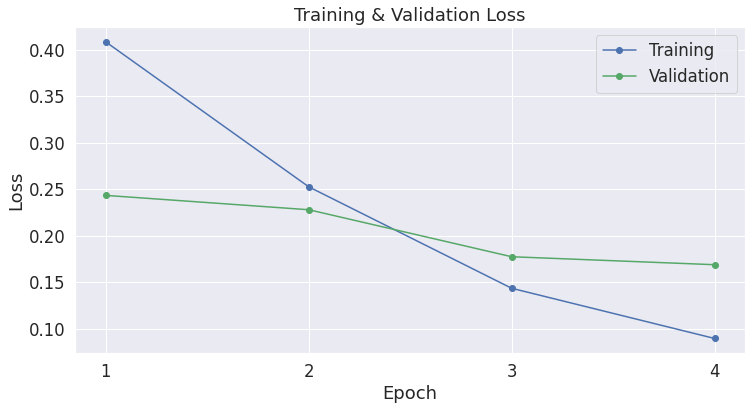

In [ ]:
#@title 딥러닝 학습 간단 보기

import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
print(df_stats.to_string())


import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()




##### 테스트 모델을 통한 모델 정확도 #####
Accuracy: 0.90
Test took: 0:00:06

              precision    recall  f1-score   support

    hanfeizi       0.93      0.87      0.90        87
   zhanguoce       0.86      0.92      0.89        76

    accuracy                           0.90       163
   macro avg       0.90      0.90      0.90       163
weighted avg       0.90      0.90      0.90       163




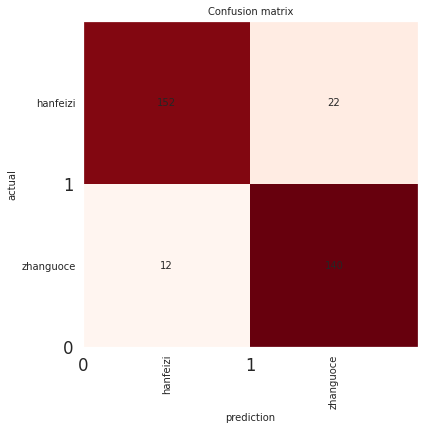

In [ ]:
#@title 딥러닝 학습 평가하기

라벨링 = ['hanfeizi','zhanguoce']  #@param


#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()


# Tracking variables 
predictions , true_labels, predictionsfin = [], [], []

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("##### 테스트 모델을 통한 모델 정확도 #####")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))


## 테스트 데이터를 대상으로 하는 모델 상세 평가
## precision = 정밀도 = 실제로는 False이지만 True로 라벨링 한 것에 집중
## 실제로는 스팸메일이 아니지만 스펨 메일로 라벨링하면?!
## recall = 재현율 = 실제 True인데 False 라벨링한 것에 집중
## 실제로는 코로나 감염자이지만, 코로나 감염이 아니라고 하면?!
## F1 = 정밀도와 재현율의 조화평균

rounded_labels_set = []
rounded_predictions_set = []

from sklearn.metrics import classification_report

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  rounded_labels = np.argmax(predictions[i], axis=1).flatten()
  rounded_labels_set.extend(rounded_labels)
  # Calculate and store the coef for this batch.  
  rounded_predictions = true_labels[i].flatten()     
  rounded_predictions_set.extend(rounded_predictions)

labels = 라벨링

print("")
print(classification_report(rounded_labels_set, rounded_predictions_set, target_names=labels))
print("")


## 혼란 매트릭스 - Confusion matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  rounded_labels = np.argmax(predictions[i], axis=1).flatten()
  rounded_labels_set.extend(rounded_labels)
  # Calculate and store the coef for this batch.  
  rounded_predictions = true_labels[i].flatten()     
  rounded_predictions_set.extend(rounded_predictions)   

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels_set, rounded_predictions_set)

def plot_confusion_matrix(
    ax, matrix, labels, title='Confusion matrix', fontsize=9):

    ax.set_xticks([x for x in range(len(labels))])
    ax.set_yticks([y for y in range(len(labels))])

    # Place labels on minor ticks
    ax.set_xticks([x + 0.5 for x in range(len(labels))], minor=True)
    ax.set_xticklabels(labels, rotation='90', fontsize=fontsize, minor=True)
    ax.set_yticks([y + 0.5 for y in range(len(labels))], minor=True)
    ax.set_yticklabels(labels[::-1], fontsize=fontsize, minor=True)

    # Hide major tick labels
    ax.tick_params(which='major', labelbottom='off', labelleft='off')

    # Finally, hide minor tick marks
    ax.tick_params(which='minor', width=0)

    # Plot heat map
    proportions = [1. * row / sum(row) for row in matrix]
    ax.pcolor(np.array(proportions[::-1]), cmap=plt.cm.Reds)

    # Plot counts as text
    for row in range(len(matrix)):
        for col in range(len(matrix[row])):
            confusion = matrix[::-1][row][col]
            if confusion != 0:
                ax.text(col + 0.5, row + 0.5, int(confusion),
                        fontsize=fontsize,
                        horizontalalignment='center',
                        verticalalignment='center')

    # Add finishing touches
    ax.grid(True, linestyle=':')
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel('prediction', fontsize=fontsize)
    ax.set_ylabel('actual', fontsize=fontsize)

    plt.show()


if __name__ == '__main__':
    matrix = cm
    labels = 라벨링
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    plot_confusion_matrix(ax, matrix, labels, fontsize=10)

## 예측 모델 실전 테스트#

In [ ]:
#@title 딥러닝 모델로 예측하기

# 初見秦
테스트용텍스트 = '\u4ECA\u79E6\u51FA\u865F\u4EE4\u800C\u884C\u8CDE\u7F70\u6709\u529F\u7121\u529F\u76F8\u4E8B\u4E5F\u51FA\u5176\u7236\u6BCD\u61F7\u887D\u4E4B\u4E2D\u751F\u672A\u5617\u898B\u5BC7\u8033\u805E\u6230\u9813\u8DB3\u5F92\u88FC\u72AF\u767D\u5203\u8E48\u946A\u70AD\u65B7\u6B7B\u65BC\u524D\u8005\u7686\u662F\u4E5F\u592B\u65B7\u6B7B\u8207\u65B7\u751F\u8005\u4E0D\u540C\u800C\u6C11\u70BA\u4E4B\u8005\u662F\u8CB4\u596E\u6B7B\u4E5F\u592B\u4E00\u4EBA\u596E\u6B7B\u53EF\u4EE5\u5C0D\u5341\u5341\u53EF\u4EE5\u5C0D\u767E\u767E\u53EF\u4EE5\u5C0D\u5343\u5343\u53EF\u4EE5\u5C0D\u842C\u842C\u53EF\u4EE5\u524B\u5929\u4E0B\u77E3'  #@param {type: "string"}

# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

logits = test_sentences([테스트용텍스트])
if np.argmax(logits) == 1:
  print("戰國策")
else:
  print("韓非子")

print(logits)


戰國策
[[-0.5710397  1.0642424]]


In [ ]:
#@title 딥러닝 모델로 예측하기

# 存韓
테스트용텍스트 = '\u4ECA\u8CE4\u81E3\u4E4B\u611A\u8A08\u4F7F\u4EBA\u4F7F\u834A\u91CD\u5F0A\u7528\u4E8B\u4E4B\u81E3\u660E\u8D99\u4E4B\u6240\u4EE5\u6B3A\u79E6\u8005\u8207\u9B4F\u8CEA\u4EE5\u5B89\u5176\u5FC3\u5F9E\u97D3\u800C\u4F10\u8D99\u8D99\u96D6\u8207\u9F4A\u70BA\u4E00\u4E0D\u8DB3\u60A3\u4E5F\u4E8C\u570B\u4E8B\u7562\u5247\u97D3\u53EF\u4EE5\u79FB\u66F8\u5B9A\u4E5F\u662F\u6211\u4E00\u8209\u4E8C\u570B\u6709\u4EA1\u5F62\u5247\u834A\u9B4F\u53C8\u5FC5\u81EA\u670D\u77E3'  #@param {type: "string"}

# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

logits = test_sentences([테스트용텍스트])
if np.argmax(logits) == 1:
  print("戰國策")
else:
  print("韓非子")

print(logits)


戰國策
[[-1.8745968  1.8008211]]


## 초현진, 존한 적용

In [ ]:
#@title 데이터 불러오기
구글드라이브ID = '1YXu0g8kdPrc5kivTVNJdJ3JQmPvwX4or'  #@param {type: "string"}
파일저장이름 = 'testing.txt'  #@param {type: "string"}

# 구글 드라이브 연결을 위한 기본 세팅
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

rawdata_downloaded = drive.CreateFile({'id': 구글드라이브ID })
rawdata_downloaded.GetContentFile(파일저장이름)

print(파일저장이름+"을 정상적으로 가져왔습니다.")

# 파일을 DataFrame으로 전환
testdata = pd.read_csv(파일저장이름, sep='\t')
testdata

testing.txt을 정상적으로 가져왔습니다.


,label,chapter,text_content
0,韓非子,初見秦,臣聞不知而言不智知而不言不忠為人臣不忠當死言而不當亦當死雖然臣願悉言所聞唯大王裁其罪
1,韓非子,初見秦,臣聞天下陰燕陽魏連荊固齊收韓而成從將西面以與秦強為難臣竊笑之世有三亡而天下得之其此之謂乎臣聞...
2,韓非子,初見秦,今秦出號令而行賞罰有功無功相事也出其父母懷衽之中生未嘗見寇耳聞戰頓足徒裼犯白刃蹈鑪炭斷死於前...
3,韓非子,初見秦,臣敢言之往者齊南破荊東破宋西服秦北破燕中使韓魏土地廣而兵強戰剋攻取詔令天下齊之清濟濁河足以為...
4,韓非子,初見秦,令荊人得收亡國聚散民立社稷主置宗廟令率天下西面以與秦為難此固以失霸王之道一矣天下又比周而軍華...
5,韓非子,初見秦,趙氏中央之國也雜民所居也其民輕而難用也號令不治賞罰不信地形不便下不能盡其民力彼固亡國之形也而...
6,韓非子,初見秦,然則是趙舉趙舉則韓亡韓亡則荊魏不能獨立荊魏不能獨立則是一舉而壞韓蠹魏拔荊東以弱齊燕決白馬之口...
7,韓非子,初見秦,軍乃引而復并於孚下大王又并軍而至與戰不能剋之也又不能反運罷而去天下固量秦力三矣內者量吾謀臣外...
8,韓非子,初見秦,且臣聞之曰戰戰栗栗日慎一日苟慎其道天下可有何以知其然也昔者紂為天子將率天下甲兵百萬左飲於淇溪...
9,韓非子,初見秦,今秦地折長補短方數千里名師數十百萬秦國之號令賞罰地形利害天下莫如也以此與天下天下可兼而有也臣...


In [ ]:
결과종합 = []
for i in range(len(testdata)):# 원본데이터의 컬럼(열)을 불러와서 반복할 준비!
    대상텍스트 = testdata['text_content'][i] # 분석에서 사용할 텍스트 정보가 있는 열을 지정해준다. 주의! python은 0부터 시작한다!
    #logits = 0
    logits = test_sentences([대상텍스트])
    감정판단 = str(np.argmax(logits))
    결과종합.append(감정판단)
    #df[['none'][index]] = logits[0][0]
    #df['true'] = logits[0][1]
 
testdata['분류판단'] = 결과종합

In [ ]:
결과종합 = []
for i in range(len(testdata)):# 원본데이터의 컬럼(열)을 불러와서 반복할 준비!
    대상텍스트 = testdata['text_content'][i] # 분석에서 사용할 텍스트 정보가 있는 열을 지정해준다. 주의! python은 0부터 시작한다!
    #logits = 0
    logits = test_sentences([대상텍스트])
    긍정 = logits[0][0]
    결과종합.append(긍정)
    #df[['none'][index]] = logits[0][0]
    #df['true'] = logits[0][1]
 
testdata['한비자 추정치'] = 결과종합


In [ ]:

결과종합 = []
for i in range(len(testdata)):# 원본데이터의 컬럼(열)을 불러와서 반복할 준비!
    대상텍스트 = testdata['text_content'][i] # 분석에서 사용할 텍스트 정보가 있는 열을 지정해준다. 주의! python은 0부터 시작한다!
    #logits = 0
    logits = test_sentences([대상텍스트])
    부정 = logits[0][1]
    결과종합.append(부정)
    #df[['none'][index]] = logits[0][0]
    #df['true'] = logits[0][1]
 
testdata['전국책 추청지'] = 결과종합


In [ ]:
testdata

,label,chapter,text_content,분류판단,한비자 추정치,전국책 추청지
0,韓非子,初見秦,臣聞不知而言不智知而不言不忠為人臣不忠當死言而不當亦當死雖然臣願悉言所聞唯大王裁其罪,0,1.89,-2.41
1,韓非子,初見秦,臣聞天下陰燕陽魏連荊固齊收韓而成從將西面以與秦強為難臣竊笑之世有三亡而天下得之其此之謂乎臣聞...,0,0.34,-0.21
2,韓非子,初見秦,今秦出號令而行賞罰有功無功相事也出其父母懷衽之中生未嘗見寇耳聞戰頓足徒裼犯白刃蹈鑪炭斷死於前...,1,-1.92,2.45
3,韓非子,初見秦,臣敢言之往者齊南破荊東破宋西服秦北破燕中使韓魏土地廣而兵強戰剋攻取詔令天下齊之清濟濁河足以為...,0,0.07,-0.06
4,韓非子,初見秦,令荊人得收亡國聚散民立社稷主置宗廟令率天下西面以與秦為難此固以失霸王之道一矣天下又比周而軍華...,1,0.17,0.17
5,韓非子,初見秦,趙氏中央之國也雜民所居也其民輕而難用也號令不治賞罰不信地形不便下不能盡其民力彼固亡國之形也而...,0,0.47,-0.69
6,韓非子,初見秦,然則是趙舉趙舉則韓亡韓亡則荊魏不能獨立荊魏不能獨立則是一舉而壞韓蠹魏拔荊東以弱齊燕決白馬之口...,0,0.70,-0.96
7,韓非子,初見秦,軍乃引而復并於孚下大王又并軍而至與戰不能剋之也又不能反運罷而去天下固量秦力三矣內者量吾謀臣外...,1,-0.76,1.09
8,韓非子,初見秦,且臣聞之曰戰戰栗栗日慎一日苟慎其道天下可有何以知其然也昔者紂為天子將率天下甲兵百萬左飲於淇溪...,1,-1.65,1.60
9,韓非子,初見秦,今秦地折長補短方數千里名師數十百萬秦國之號令賞罰地形利害天下莫如也以此與天下天下可兼而有也臣...,1,-2.59,2.83


In [ ]:
testdata.to_csv('예측결과.csv', sep="\t", header='true', encoding='utf-8')